# Washington flood data from december 2025

This notebook provides climatic context for the December 2025 event in Washington using publicly available data sources and APIs.

- **USGS**: Stream gauge data for river discharge and flooding.
- **NOAA**: Precipitation data for rainfall and snow.

We will use Python libraries to access, process, and visualize this data.

In [2]:
# libraries 
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt

## Accessing USGS Stream Gauge Data

Using USGS Water Services API to retrieve real-time river discharge data:
- **Site 12451000**: Stehekin River at Stehekin, WA
- **Parameter 00060**: Discharge (cubic feet per second)
- **Period**: December 01-31, 2025


In [20]:
# API endpoint & params
usgs_url = "https://waterservices.usgs.gov/nwis/iv/"
params = {
    "format": "json",
    "sites": "12451000",
    "parameterCd": "00060",
    "startDT": "2025-12-01",
    "endDT": "2025-12-31"
}

# Fetch
resp = requests.get(usgs_url, params=params)
resp.raise_for_status()
data = resp.json()

# Parse into DataFrame
discharge = []
for ts in data["value"]["timeSeries"]:
    site = ts["sourceInfo"]["siteCode"][0]["value"]
    name = ts["sourceInfo"]["siteName"]
    for val in ts["values"][0]["value"]:
        discharge.append({
            "site": site,
            "name": name,
            "datetime": val["dateTime"],
            "discharge_cfs": float(val["value"])
        })

discharge_df = pd.DataFrame(discharge)
discharge_df["datetime"] = pd.to_datetime(discharge_df["datetime"])


## Accessing NOAA Precipitation Data

Using NOAA's Climate Data Online (CDO) Web Services API to retrieve daily precipitation data:
- **Station GHCND:USC00458059**: Stehekin 4 NW, WA US
- **Data type**: Daily precipitation (PRCP)
- **Period**: December 01-31, 2025


In [21]:
# API endpoint & params
token = "BgisjyvDOKLEcfeFOtxYWAcFzQRGfSoI" #API token and keys should be kept secret
headers = {"token": token}
noaa_url = "https://www.ncei.noaa.gov/cdo-web/api/v2/data"
params = {
    "datasetid": "GHCND",
    "datatypeid": "PRCP",
    "stationid": "GHCND:USC00458059",
    "startdate": "2025-12-01",
    "enddate": "2025-12-31",
    "units": "metric",
    "limit": 1000
}

# Fetch
resp = requests.get(noaa_url, headers=headers, params=params)
resp.raise_for_status()
data = resp.json()

# Parse into DataFrame
precipitation = []
results = data.get("results", [])
for record in results:
    precipitation.append({
        "site": record["station"],
        "name": "Stehekin 4 NW, WA US",
        "datetime": record["date"],
        "precip_mm": float(record["value"]) / 10  # Convert from tenths of mm to mm
    })

precip_df = pd.DataFrame(precipitation)
precip_df["datetime"] = pd.to_datetime(precip_df["datetime"])

print(precip_df.head())

                site                  name   datetime  precip_mm
0  GHCND:USC00458059  Stehekin 4 NW, WA US 2025-12-01       0.00
1  GHCND:USC00458059  Stehekin 4 NW, WA US 2025-12-02       0.41
2  GHCND:USC00458059  Stehekin 4 NW, WA US 2025-12-03       0.00
3  GHCND:USC00458059  Stehekin 4 NW, WA US 2025-12-04       0.15
4  GHCND:USC00458059  Stehekin 4 NW, WA US 2025-12-05       0.51


## Discharge and Precipitation pplot of december 2025

Plot of both discharge and precipitation on for December of 2025 to examine the relationship between pecipitation and river discharge during the December 2025 flood event. The peak discharge is marked to identify the maximum flow.

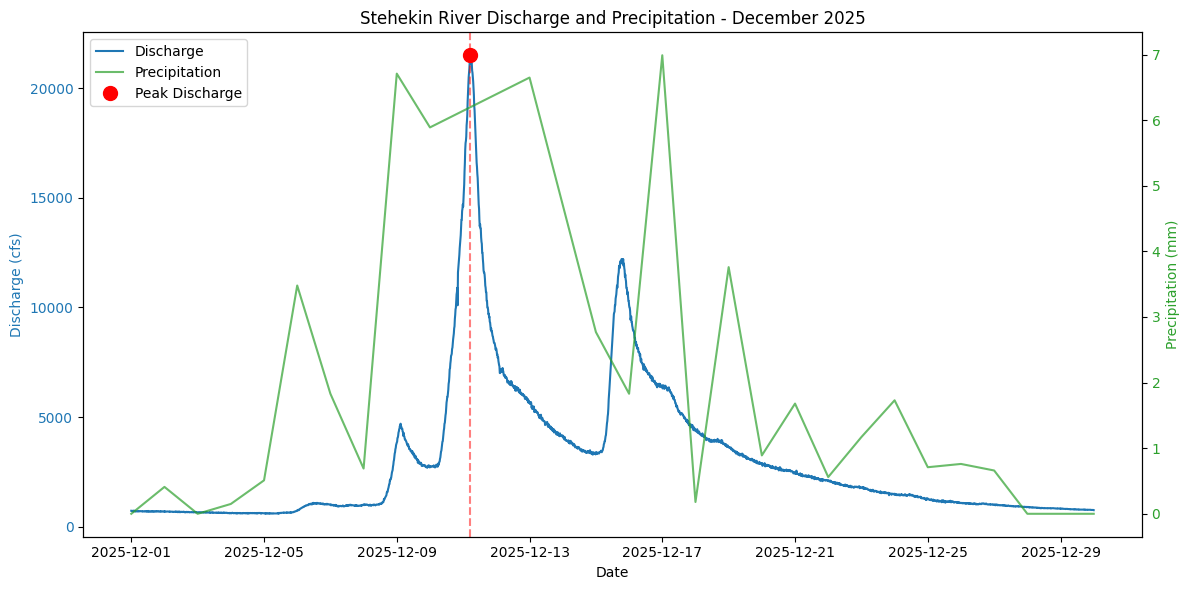

In [22]:
## Combined Analysis: Discharge and Precipitation

#Plot discharge and precipitation together to examine the relationship during the December 2025 event. Mark the peak in discharge.

# Convert both datetime columns to timezone-naive to allow comparison
discharge_df["datetime"] = discharge_df["datetime"].dt.tz_localize(None)
precip_df["datetime"] = precip_df["datetime"].dt.tz_localize(None)

# Find common start date for both dataframes
start_date = max(discharge_df["datetime"].min(), precip_df["datetime"].min())
end_date = min(discharge_df["datetime"].max(), precip_df["datetime"].max())

# Filter both dataframes to same date range
discharge_filtered = discharge_df[(discharge_df["datetime"] >= start_date) & (discharge_df["datetime"] <= end_date)]
precip_filtered = precip_df[(precip_df["datetime"] >= start_date) & (precip_df["datetime"] <= end_date)]

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot discharge on left axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Discharge (cfs)', color=color)
line1 = ax1.plot(discharge_filtered["datetime"], discharge_filtered["discharge_cfs"], color=color, label='Discharge')
ax1.tick_params(axis='y', labelcolor=color)

# Create second y-axis for precipitation
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Precipitation (mm)', color=color)
line2 = ax2.plot(precip_filtered["datetime"], precip_filtered["precip_mm"], color=color, label='Precipitation', alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color)

# Find and mark the biggest peak in discharge
peak_idx = discharge_filtered["discharge_cfs"].idxmax()
peak_date = discharge_filtered.loc[peak_idx, "datetime"]
peak_value = discharge_filtered.loc[peak_idx, "discharge_cfs"]
line3 = ax1.plot(peak_date, peak_value, 'ro', markersize=10, label='Peak Discharge')
ax1.axvline(x=peak_date, color='red', linestyle='--', alpha=0.5)

# Combine legends from both axes
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title("Stehekin River Discharge and Precipitation - December 2025")
plt.tight_layout()
plt.show()

## Historical information context